# **Aspect Based Sentiment Analysis: (3 Classes) - Laptop - ABSA Dataset**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.8 MB/s eta 0:00:00


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from peft import LoraConfig, TaskType, get_peft_model


### Step 2: Mount Google Drive & Load Data

In [36]:
#file_path = "/home/arafatmdeasin/usman/project/dataset/IMDB Dataset (2 Classes).csv"

#df = pd.read_csv(file_path, encoding='ISO-8859-1')
#df = df[['Text', 'Sentiment']].dropna()
#df.head()

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Restaurant - ABSA.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Text,Sentiment
0,But the staff was so horrible to us.,Negative
1,To be completely fair[comma] the only redeemin...,Positive
2,The food is uniformly exceptional[comma] with ...,Positive
3,The food is uniformly exceptional[comma] with ...,Positive
4,The food is uniformly exceptional[comma] with ...,Neutral


### Step 3: Visualize Dataset Distribution

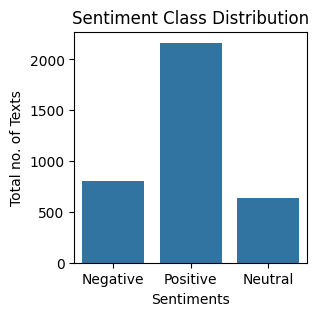

In [37]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [38]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Mapping:
Negative: 0
Neutral: 1
Positive: 2


### Step 5: Train-Test Split

In [39]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)


### Step 6: Tokenization

In [40]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

base_model_name = "microsoft/deberta-v3-base"
finetuned_model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Step 7: Dataset Class

In [41]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)


### Step 9: Define Metrics Function

In [42]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


### Step 10: Evaluate Without Fine-Tuning

In [43]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(output_dir="./results", per_device_eval_batch_size=32),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()
print("Performance without Fine-Tuning:", baseline_metrics)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Performance without Fine-Tuning: {'eval_loss': 0.664090633392334, 'eval_accuracy': 0.7226074895977809, 'eval_precision': 0.7537655270367181, 'eval_recall': 0.7226074895977809, 'eval_f1': 0.7338656390409195, 'eval_runtime': 1.6946, 'eval_samples_per_second': 425.465, 'eval_steps_per_second': 13.572}


#### Step 10.1:Confusion Matrix (Without Fine-Tuning)

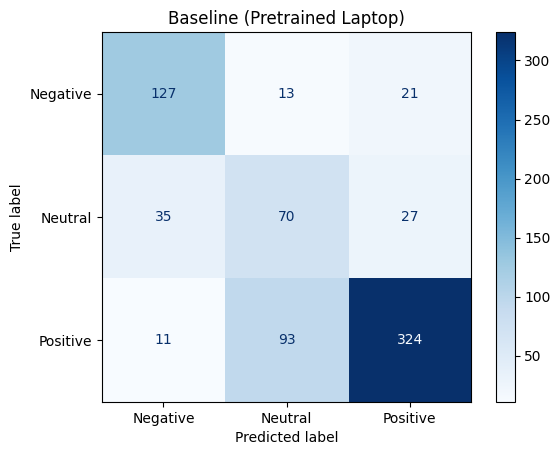

In [44]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Baseline (Pretrained Laptop)")
plt.show()


### Step 11: Load the Base Model

In [45]:
model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_)
)

training_args = TrainingArguments(
    output_dir="./results-base",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    report_to="none",
    seed=42
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_base.train()
finetuned_metrics = trainer_base.evaluate()

print("Performance after Fine-Tuning Base Model:", finetuned_metrics)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.718200,0.588700,0.785021,0.773554,0.785021,0.770510
2,0.482200,0.545559,0.780860,0.778939,0.780860,0.779843
3,0.376500,0.573404,0.787795,0.781323,0.787795,0.783800


Performance after Fine-Tuning Base Model: {'eval_loss': 0.5455585718154907, 'eval_accuracy': 0.7808599167822469, 'eval_precision': 0.7789387229499486, 'eval_recall': 0.7808599167822469, 'eval_f1': 0.7798431910652099, 'eval_runtime': 1.6145, 'eval_samples_per_second': 446.578, 'eval_steps_per_second': 14.246, 'epoch': 3.0}


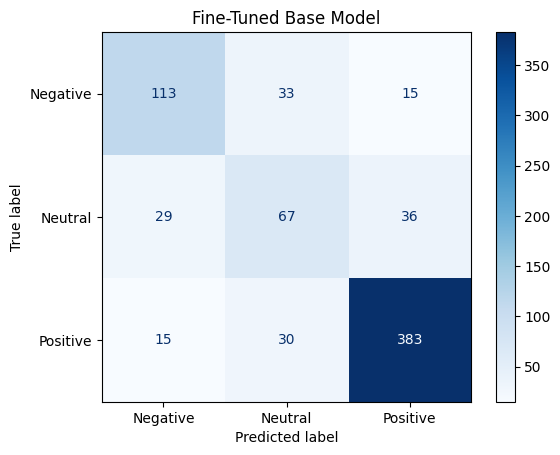

In [46]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Fine-Tuned Base Model")
plt.show()


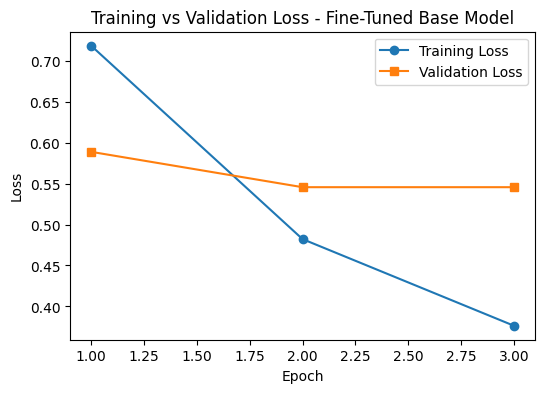

In [47]:
import matplotlib.pyplot as plt

logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(6,4))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


In [50]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_)
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"],
)

adapter_model = get_peft_model(adapter_model, peft_config)

adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    report_to="none",
    seed=42
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_adapter.train()
adapter_metrics = trainer_adapter.evaluate()

print("Performance with Adapter (LoRA):", adapter_metrics)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.812500,0.591707,0.753121,0.618025,0.753121,0.678601
2,0.489400,0.604673,0.771151,0.767013,0.771151,0.768872
3,0.445500,0.620444,0.772538,0.767846,0.772538,0.769976


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is dep

Performance with Adapter (LoRA): {'eval_loss': 0.5704067349433899, 'eval_accuracy': 0.7642163661581137, 'eval_precision': 0.7566764261827721, 'eval_recall': 0.7642163661581137, 'eval_f1': 0.759964892726987, 'eval_runtime': 4.6746, 'eval_samples_per_second': 154.237, 'eval_steps_per_second': 19.467, 'epoch': 3.9944521497919556}


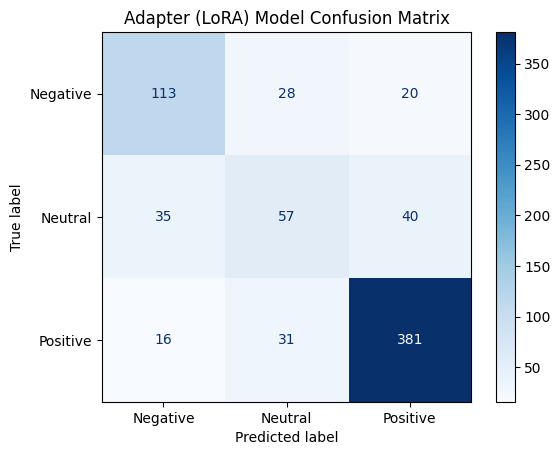

In [51]:

preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.show()

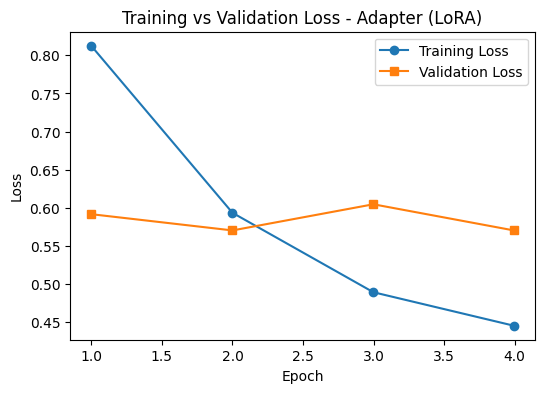

In [52]:
logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(6,4))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()
